# HAR LSTM training 

In [1]:
# Imports
import numpy as np
import os
from utils.utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [2]:
X_train, labels_train, list_ch_train = read_data(data_path="./UCIHAR/", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path="./UCIHAR/", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

/home/gabriele/Documents/TestingArea/DeepLearningHAR/utils/utilities.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X[:,:,i_ch] = dat_.as_matrix()


In [3]:
# Standardize
X_train, X_test = standardize(X_train, X_test) 

Train/Validation Split

In [4]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train,
                                                random_state = 123)

One-hot encoding:

In [5]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

### Hyperparameters

In [6]:
# Imports
import tensorflow as tf

lstm_size = 27         # 3 times the amount of channels
lstm_layers = 2        # Number of layers
batch_size = 600       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.0001  # Learning rate (default is 0.001)
epochs = 1000

# Fixed
n_classes = 6
n_channels = 9

### Construct the graph
Placeholders

In [7]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Construct inputs to LSTM

In [8]:
with graph.as_default():
    # Construct the LSTM inputs and LSTM cells
    lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
    lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
    
    # To cells
    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    
    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)
    
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)

Define forward pass, cost function and optimizer:

In [9]:
with graph.as_default():
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                     initial_state = initial_state)
    
    # We only need the last output tensor to pass into a classifier
    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    #optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost) # No grad clipping
    
    # Grad clipping
    train_op = tf.train.AdamOptimizer(learning_rate_)

    gradients = train_op.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    optimizer = train_op.apply_gradients(capped_gradients)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [10]:
if (os.path.exists('checkpoints') == False):
    !mkdir checkpoints

In [11]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, 
                    initial_state : state, learning_rate_ : learning_rate}
            
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 25 iterations
            if (iteration%25 == 0):
                
                # Initiate for validation set
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                val_acc_ = []
                val_loss_ = []
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0, initial_state : val_state}
                    
                    # Loss
                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints/har-lstm.ckpt")

Epoch: 0/1000 Iteration: 5 Train loss: 1.723042 Train acc: 0.251667
Epoch: 1/1000 Iteration: 10 Train loss: 1.727174 Train acc: 0.280000
Epoch: 1/1000 Iteration: 15 Train loss: 1.707648 Train acc: 0.293333
Epoch: 2/1000 Iteration: 20 Train loss: 1.700410 Train acc: 0.316667
Epoch: 2/1000 Iteration: 25 Train loss: 1.693401 Train acc: 0.300000
Epoch: 2/1000 Iteration: 25 Validation loss: 1.671177 Validation acc: 0.353333
Epoch: 3/1000 Iteration: 30 Train loss: 1.698720 Train acc: 0.283333
Epoch: 3/1000 Iteration: 35 Train loss: 1.664191 Train acc: 0.340000
Epoch: 4/1000 Iteration: 40 Train loss: 1.676474 Train acc: 0.298333
Epoch: 4/1000 Iteration: 45 Train loss: 1.658575 Train acc: 0.305000
Epoch: 5/1000 Iteration: 50 Train loss: 1.612534 Train acc: 0.361667
Epoch: 5/1000 Iteration: 50 Validation loss: 1.608245 Validation acc: 0.423333
Epoch: 6/1000 Iteration: 55 Train loss: 1.621511 Train acc: 0.356667
Epoch: 6/1000 Iteration: 60 Train loss: 1.600870 Train acc: 0.368333
Epoch: 7/1000 I

Epoch: 53/1000 Iteration: 480 Train loss: 0.865386 Train acc: 0.675000
Epoch: 53/1000 Iteration: 485 Train loss: 0.817836 Train acc: 0.733333
Epoch: 54/1000 Iteration: 490 Train loss: 0.867659 Train acc: 0.673333
Epoch: 54/1000 Iteration: 495 Train loss: 0.836954 Train acc: 0.710000
Epoch: 55/1000 Iteration: 500 Train loss: 0.810962 Train acc: 0.708333
Epoch: 55/1000 Iteration: 500 Validation loss: 0.711034 Validation acc: 0.790556
Epoch: 56/1000 Iteration: 505 Train loss: 0.793668 Train acc: 0.708333
Epoch: 56/1000 Iteration: 510 Train loss: 0.772039 Train acc: 0.735000
Epoch: 57/1000 Iteration: 515 Train loss: 0.825131 Train acc: 0.698333
Epoch: 57/1000 Iteration: 520 Train loss: 0.820370 Train acc: 0.695000
Epoch: 58/1000 Iteration: 525 Train loss: 0.825078 Train acc: 0.700000
Epoch: 58/1000 Iteration: 525 Validation loss: 0.673842 Validation acc: 0.797222
Epoch: 58/1000 Iteration: 530 Train loss: 0.759223 Train acc: 0.710000
Epoch: 59/1000 Iteration: 535 Train loss: 0.798556 Train 

Epoch: 105/1000 Iteration: 950 Validation loss: 0.396030 Validation acc: 0.837778
Epoch: 106/1000 Iteration: 955 Train loss: 0.474972 Train acc: 0.818333
Epoch: 106/1000 Iteration: 960 Train loss: 0.478769 Train acc: 0.815000
Epoch: 107/1000 Iteration: 965 Train loss: 0.485147 Train acc: 0.813333
Epoch: 107/1000 Iteration: 970 Train loss: 0.490665 Train acc: 0.791667
Epoch: 108/1000 Iteration: 975 Train loss: 0.514089 Train acc: 0.780000
Epoch: 108/1000 Iteration: 975 Validation loss: 0.391819 Validation acc: 0.837778
Epoch: 108/1000 Iteration: 980 Train loss: 0.488063 Train acc: 0.791667
Epoch: 109/1000 Iteration: 985 Train loss: 0.530897 Train acc: 0.783333
Epoch: 109/1000 Iteration: 990 Train loss: 0.500904 Train acc: 0.786667
Epoch: 110/1000 Iteration: 995 Train loss: 0.477688 Train acc: 0.796667
Epoch: 111/1000 Iteration: 1000 Train loss: 0.491554 Train acc: 0.786667
Epoch: 111/1000 Iteration: 1000 Validation loss: 0.386853 Validation acc: 0.837778
Epoch: 111/1000 Iteration: 1005 

Epoch: 156/1000 Iteration: 1410 Train loss: 0.392982 Train acc: 0.835000
Epoch: 157/1000 Iteration: 1415 Train loss: 0.409186 Train acc: 0.843333
Epoch: 157/1000 Iteration: 1420 Train loss: 0.405119 Train acc: 0.833333
Epoch: 158/1000 Iteration: 1425 Train loss: 0.456446 Train acc: 0.801667
Epoch: 158/1000 Iteration: 1425 Validation loss: 0.328317 Validation acc: 0.891667
Epoch: 158/1000 Iteration: 1430 Train loss: 0.411950 Train acc: 0.841667
Epoch: 159/1000 Iteration: 1435 Train loss: 0.446277 Train acc: 0.821667
Epoch: 159/1000 Iteration: 1440 Train loss: 0.416693 Train acc: 0.835000
Epoch: 160/1000 Iteration: 1445 Train loss: 0.399572 Train acc: 0.850000
Epoch: 161/1000 Iteration: 1450 Train loss: 0.399881 Train acc: 0.836667
Epoch: 161/1000 Iteration: 1450 Validation loss: 0.325468 Validation acc: 0.895000
Epoch: 161/1000 Iteration: 1455 Train loss: 0.398794 Train acc: 0.826667
Epoch: 162/1000 Iteration: 1460 Train loss: 0.415429 Train acc: 0.840000
Epoch: 162/1000 Iteration: 1465

Epoch: 207/1000 Iteration: 1870 Train loss: 0.297326 Train acc: 0.910000
Epoch: 208/1000 Iteration: 1875 Train loss: 0.328886 Train acc: 0.910000
Epoch: 208/1000 Iteration: 1875 Validation loss: 0.207914 Validation acc: 0.948333
Epoch: 208/1000 Iteration: 1880 Train loss: 0.270508 Train acc: 0.940000
Epoch: 209/1000 Iteration: 1885 Train loss: 0.322988 Train acc: 0.910000
Epoch: 209/1000 Iteration: 1890 Train loss: 0.294768 Train acc: 0.921667
Epoch: 210/1000 Iteration: 1895 Train loss: 0.275422 Train acc: 0.938333
Epoch: 211/1000 Iteration: 1900 Train loss: 0.279600 Train acc: 0.918333
Epoch: 211/1000 Iteration: 1900 Validation loss: 0.203995 Validation acc: 0.949444
Epoch: 211/1000 Iteration: 1905 Train loss: 0.256944 Train acc: 0.930000
Epoch: 212/1000 Iteration: 1910 Train loss: 0.277546 Train acc: 0.936667
Epoch: 212/1000 Iteration: 1915 Train loss: 0.275532 Train acc: 0.925000
Epoch: 213/1000 Iteration: 1920 Train loss: 0.306847 Train acc: 0.906667
Epoch: 213/1000 Iteration: 1925

Epoch: 258/1000 Iteration: 2325 Validation loss: 0.160438 Validation acc: 0.955000
Epoch: 258/1000 Iteration: 2330 Train loss: 0.220096 Train acc: 0.953333
Epoch: 259/1000 Iteration: 2335 Train loss: 0.260507 Train acc: 0.905000
Epoch: 259/1000 Iteration: 2340 Train loss: 0.258559 Train acc: 0.931667
Epoch: 260/1000 Iteration: 2345 Train loss: 0.213425 Train acc: 0.940000
Epoch: 261/1000 Iteration: 2350 Train loss: 0.208789 Train acc: 0.950000
Epoch: 261/1000 Iteration: 2350 Validation loss: 0.156467 Validation acc: 0.956667
Epoch: 261/1000 Iteration: 2355 Train loss: 0.224187 Train acc: 0.946667
Epoch: 262/1000 Iteration: 2360 Train loss: 0.228472 Train acc: 0.931667
Epoch: 262/1000 Iteration: 2365 Train loss: 0.235321 Train acc: 0.948333
Epoch: 263/1000 Iteration: 2370 Train loss: 0.241635 Train acc: 0.928333
Epoch: 263/1000 Iteration: 2375 Train loss: 0.190938 Train acc: 0.960000
Epoch: 263/1000 Iteration: 2375 Validation loss: 0.155579 Validation acc: 0.957222
Epoch: 264/1000 Itera

Epoch: 309/1000 Iteration: 2785 Train loss: 0.217735 Train acc: 0.936667
Epoch: 309/1000 Iteration: 2790 Train loss: 0.234699 Train acc: 0.936667
Epoch: 310/1000 Iteration: 2795 Train loss: 0.204339 Train acc: 0.945000
Epoch: 311/1000 Iteration: 2800 Train loss: 0.187892 Train acc: 0.956667
Epoch: 311/1000 Iteration: 2800 Validation loss: 0.133977 Validation acc: 0.958333
Epoch: 311/1000 Iteration: 2805 Train loss: 0.169362 Train acc: 0.968333
Epoch: 312/1000 Iteration: 2810 Train loss: 0.187617 Train acc: 0.955000
Epoch: 312/1000 Iteration: 2815 Train loss: 0.195638 Train acc: 0.950000
Epoch: 313/1000 Iteration: 2820 Train loss: 0.213382 Train acc: 0.941667
Epoch: 313/1000 Iteration: 2825 Train loss: 0.171242 Train acc: 0.956667
Epoch: 313/1000 Iteration: 2825 Validation loss: 0.133436 Validation acc: 0.957778
Epoch: 314/1000 Iteration: 2830 Train loss: 0.231868 Train acc: 0.921667
Epoch: 314/1000 Iteration: 2835 Train loss: 0.195193 Train acc: 0.943333
Epoch: 315/1000 Iteration: 2840

Epoch: 360/1000 Iteration: 3245 Train loss: 0.164554 Train acc: 0.953333
Epoch: 361/1000 Iteration: 3250 Train loss: 0.163198 Train acc: 0.955000
Epoch: 361/1000 Iteration: 3250 Validation loss: 0.124560 Validation acc: 0.953333
Epoch: 361/1000 Iteration: 3255 Train loss: 0.165823 Train acc: 0.956667
Epoch: 362/1000 Iteration: 3260 Train loss: 0.164525 Train acc: 0.960000
Epoch: 362/1000 Iteration: 3265 Train loss: 0.158101 Train acc: 0.961667
Epoch: 363/1000 Iteration: 3270 Train loss: 0.208906 Train acc: 0.943333
Epoch: 363/1000 Iteration: 3275 Train loss: 0.144852 Train acc: 0.960000
Epoch: 363/1000 Iteration: 3275 Validation loss: 0.127102 Validation acc: 0.953333
Epoch: 364/1000 Iteration: 3280 Train loss: 0.194298 Train acc: 0.941667
Epoch: 364/1000 Iteration: 3285 Train loss: 0.179241 Train acc: 0.941667
Epoch: 365/1000 Iteration: 3290 Train loss: 0.160382 Train acc: 0.953333
Epoch: 366/1000 Iteration: 3295 Train loss: 0.162185 Train acc: 0.956667
Epoch: 366/1000 Iteration: 3300

Epoch: 411/1000 Iteration: 3700 Validation loss: 0.117039 Validation acc: 0.956111
Epoch: 411/1000 Iteration: 3705 Train loss: 0.141824 Train acc: 0.963333
Epoch: 412/1000 Iteration: 3710 Train loss: 0.165265 Train acc: 0.956667
Epoch: 412/1000 Iteration: 3715 Train loss: 0.163854 Train acc: 0.955000
Epoch: 413/1000 Iteration: 3720 Train loss: 0.186829 Train acc: 0.945000
Epoch: 413/1000 Iteration: 3725 Train loss: 0.137432 Train acc: 0.965000
Epoch: 413/1000 Iteration: 3725 Validation loss: 0.121634 Validation acc: 0.954444
Epoch: 414/1000 Iteration: 3730 Train loss: 0.190655 Train acc: 0.941667
Epoch: 414/1000 Iteration: 3735 Train loss: 0.183834 Train acc: 0.951667
Epoch: 415/1000 Iteration: 3740 Train loss: 0.156482 Train acc: 0.951667
Epoch: 416/1000 Iteration: 3745 Train loss: 0.162611 Train acc: 0.958333
Epoch: 416/1000 Iteration: 3750 Train loss: 0.141872 Train acc: 0.963333
Epoch: 416/1000 Iteration: 3750 Validation loss: 0.119063 Validation acc: 0.955000
Epoch: 417/1000 Itera

Epoch: 462/1000 Iteration: 4160 Train loss: 0.145296 Train acc: 0.958333
Epoch: 462/1000 Iteration: 4165 Train loss: 0.129340 Train acc: 0.963333
Epoch: 463/1000 Iteration: 4170 Train loss: 0.165777 Train acc: 0.945000
Epoch: 463/1000 Iteration: 4175 Train loss: 0.118532 Train acc: 0.971667
Epoch: 463/1000 Iteration: 4175 Validation loss: 0.118067 Validation acc: 0.954444
Epoch: 464/1000 Iteration: 4180 Train loss: 0.176500 Train acc: 0.936667
Epoch: 464/1000 Iteration: 4185 Train loss: 0.161574 Train acc: 0.953333
Epoch: 465/1000 Iteration: 4190 Train loss: 0.139797 Train acc: 0.955000
Epoch: 466/1000 Iteration: 4195 Train loss: 0.142293 Train acc: 0.951667
Epoch: 466/1000 Iteration: 4200 Train loss: 0.136399 Train acc: 0.953333
Epoch: 466/1000 Iteration: 4200 Validation loss: 0.114802 Validation acc: 0.958333
Epoch: 467/1000 Iteration: 4205 Train loss: 0.159465 Train acc: 0.956667
Epoch: 467/1000 Iteration: 4210 Train loss: 0.139885 Train acc: 0.953333
Epoch: 468/1000 Iteration: 4215

Epoch: 513/1000 Iteration: 4620 Train loss: 0.159492 Train acc: 0.945000
Epoch: 513/1000 Iteration: 4625 Train loss: 0.115119 Train acc: 0.970000
Epoch: 513/1000 Iteration: 4625 Validation loss: 0.113043 Validation acc: 0.956111
Epoch: 514/1000 Iteration: 4630 Train loss: 0.161206 Train acc: 0.943333
Epoch: 514/1000 Iteration: 4635 Train loss: 0.156655 Train acc: 0.955000
Epoch: 515/1000 Iteration: 4640 Train loss: 0.143770 Train acc: 0.956667
Epoch: 516/1000 Iteration: 4645 Train loss: 0.129876 Train acc: 0.953333
Epoch: 516/1000 Iteration: 4650 Train loss: 0.122931 Train acc: 0.966667
Epoch: 516/1000 Iteration: 4650 Validation loss: 0.112097 Validation acc: 0.956667
Epoch: 517/1000 Iteration: 4655 Train loss: 0.143106 Train acc: 0.956667
Epoch: 517/1000 Iteration: 4660 Train loss: 0.139461 Train acc: 0.955000
Epoch: 518/1000 Iteration: 4665 Train loss: 0.153747 Train acc: 0.948333
Epoch: 518/1000 Iteration: 4670 Train loss: 0.111485 Train acc: 0.970000
Epoch: 519/1000 Iteration: 4675

Epoch: 563/1000 Iteration: 5075 Validation loss: 0.108948 Validation acc: 0.955000
Epoch: 564/1000 Iteration: 5080 Train loss: 0.155723 Train acc: 0.938333
Epoch: 564/1000 Iteration: 5085 Train loss: 0.138563 Train acc: 0.953333
Epoch: 565/1000 Iteration: 5090 Train loss: 0.134265 Train acc: 0.955000
Epoch: 566/1000 Iteration: 5095 Train loss: 0.117127 Train acc: 0.968333
Epoch: 566/1000 Iteration: 5100 Train loss: 0.123835 Train acc: 0.963333
Epoch: 566/1000 Iteration: 5100 Validation loss: 0.106414 Validation acc: 0.958333
Epoch: 567/1000 Iteration: 5105 Train loss: 0.138159 Train acc: 0.963333
Epoch: 567/1000 Iteration: 5110 Train loss: 0.120015 Train acc: 0.965000
Epoch: 568/1000 Iteration: 5115 Train loss: 0.141066 Train acc: 0.950000
Epoch: 568/1000 Iteration: 5120 Train loss: 0.089443 Train acc: 0.976667
Epoch: 569/1000 Iteration: 5125 Train loss: 0.150341 Train acc: 0.953333
Epoch: 569/1000 Iteration: 5125 Validation loss: 0.106595 Validation acc: 0.957222
Epoch: 569/1000 Itera

Epoch: 614/1000 Iteration: 5535 Train loss: 0.146534 Train acc: 0.950000
Epoch: 615/1000 Iteration: 5540 Train loss: 0.123433 Train acc: 0.958333
Epoch: 616/1000 Iteration: 5545 Train loss: 0.118493 Train acc: 0.973333
Epoch: 616/1000 Iteration: 5550 Train loss: 0.116085 Train acc: 0.968333
Epoch: 616/1000 Iteration: 5550 Validation loss: 0.104884 Validation acc: 0.958889
Epoch: 617/1000 Iteration: 5555 Train loss: 0.122175 Train acc: 0.965000
Epoch: 617/1000 Iteration: 5560 Train loss: 0.135590 Train acc: 0.953333
Epoch: 618/1000 Iteration: 5565 Train loss: 0.127563 Train acc: 0.960000
Epoch: 618/1000 Iteration: 5570 Train loss: 0.086824 Train acc: 0.976667
Epoch: 619/1000 Iteration: 5575 Train loss: 0.147428 Train acc: 0.946667
Epoch: 619/1000 Iteration: 5575 Validation loss: 0.106281 Validation acc: 0.957778
Epoch: 619/1000 Iteration: 5580 Train loss: 0.142761 Train acc: 0.951667
Epoch: 620/1000 Iteration: 5585 Train loss: 0.124842 Train acc: 0.960000
Epoch: 621/1000 Iteration: 5590

Epoch: 666/1000 Iteration: 5995 Train loss: 0.104048 Train acc: 0.963333
Epoch: 666/1000 Iteration: 6000 Train loss: 0.098109 Train acc: 0.971667
Epoch: 666/1000 Iteration: 6000 Validation loss: 0.101966 Validation acc: 0.961667
Epoch: 667/1000 Iteration: 6005 Train loss: 0.128905 Train acc: 0.956667
Epoch: 667/1000 Iteration: 6010 Train loss: 0.111331 Train acc: 0.961667
Epoch: 668/1000 Iteration: 6015 Train loss: 0.137781 Train acc: 0.956667
Epoch: 668/1000 Iteration: 6020 Train loss: 0.091134 Train acc: 0.978333
Epoch: 669/1000 Iteration: 6025 Train loss: 0.129432 Train acc: 0.943333
Epoch: 669/1000 Iteration: 6025 Validation loss: 0.099958 Validation acc: 0.963889
Epoch: 669/1000 Iteration: 6030 Train loss: 0.154855 Train acc: 0.953333
Epoch: 670/1000 Iteration: 6035 Train loss: 0.113968 Train acc: 0.968333
Epoch: 671/1000 Iteration: 6040 Train loss: 0.111470 Train acc: 0.958333
Epoch: 671/1000 Iteration: 6045 Train loss: 0.100898 Train acc: 0.970000
Epoch: 672/1000 Iteration: 6050

Epoch: 716/1000 Iteration: 6450 Validation loss: 0.097539 Validation acc: 0.961111
Epoch: 717/1000 Iteration: 6455 Train loss: 0.115745 Train acc: 0.970000
Epoch: 717/1000 Iteration: 6460 Train loss: 0.109623 Train acc: 0.965000
Epoch: 718/1000 Iteration: 6465 Train loss: 0.145707 Train acc: 0.958333
Epoch: 718/1000 Iteration: 6470 Train loss: 0.089777 Train acc: 0.978333
Epoch: 719/1000 Iteration: 6475 Train loss: 0.127580 Train acc: 0.948333
Epoch: 719/1000 Iteration: 6475 Validation loss: 0.097296 Validation acc: 0.960556
Epoch: 719/1000 Iteration: 6480 Train loss: 0.122973 Train acc: 0.966667
Epoch: 720/1000 Iteration: 6485 Train loss: 0.111205 Train acc: 0.956667
Epoch: 721/1000 Iteration: 6490 Train loss: 0.098387 Train acc: 0.970000
Epoch: 721/1000 Iteration: 6495 Train loss: 0.095401 Train acc: 0.970000
Epoch: 722/1000 Iteration: 6500 Train loss: 0.114085 Train acc: 0.966667
Epoch: 722/1000 Iteration: 6500 Validation loss: 0.093952 Validation acc: 0.963333
Epoch: 722/1000 Itera

Epoch: 767/1000 Iteration: 6910 Train loss: 0.095028 Train acc: 0.970000
Epoch: 768/1000 Iteration: 6915 Train loss: 0.119083 Train acc: 0.958333
Epoch: 768/1000 Iteration: 6920 Train loss: 0.081402 Train acc: 0.976667
Epoch: 769/1000 Iteration: 6925 Train loss: 0.134850 Train acc: 0.940000
Epoch: 769/1000 Iteration: 6925 Validation loss: 0.107822 Validation acc: 0.960000
Epoch: 769/1000 Iteration: 6930 Train loss: 0.123614 Train acc: 0.953333
Epoch: 770/1000 Iteration: 6935 Train loss: 0.099382 Train acc: 0.963333
Epoch: 771/1000 Iteration: 6940 Train loss: 0.102104 Train acc: 0.966667
Epoch: 771/1000 Iteration: 6945 Train loss: 0.086073 Train acc: 0.978333
Epoch: 772/1000 Iteration: 6950 Train loss: 0.124145 Train acc: 0.966667
Epoch: 772/1000 Iteration: 6950 Validation loss: 0.101982 Validation acc: 0.959444
Epoch: 772/1000 Iteration: 6955 Train loss: 0.108777 Train acc: 0.970000
Epoch: 773/1000 Iteration: 6960 Train loss: 0.134768 Train acc: 0.955000
Epoch: 773/1000 Iteration: 6965

Epoch: 818/1000 Iteration: 7370 Train loss: 0.076854 Train acc: 0.983333
Epoch: 819/1000 Iteration: 7375 Train loss: 0.136451 Train acc: 0.953333
Epoch: 819/1000 Iteration: 7375 Validation loss: 0.099745 Validation acc: 0.959444
Epoch: 819/1000 Iteration: 7380 Train loss: 0.140930 Train acc: 0.956667
Epoch: 820/1000 Iteration: 7385 Train loss: 0.111909 Train acc: 0.963333
Epoch: 821/1000 Iteration: 7390 Train loss: 0.104612 Train acc: 0.956667
Epoch: 821/1000 Iteration: 7395 Train loss: 0.106813 Train acc: 0.965000
Epoch: 822/1000 Iteration: 7400 Train loss: 0.115811 Train acc: 0.963333
Epoch: 822/1000 Iteration: 7400 Validation loss: 0.102672 Validation acc: 0.958333
Epoch: 822/1000 Iteration: 7405 Train loss: 0.097187 Train acc: 0.978333
Epoch: 823/1000 Iteration: 7410 Train loss: 0.112734 Train acc: 0.958333
Epoch: 823/1000 Iteration: 7415 Train loss: 0.084894 Train acc: 0.973333
Epoch: 824/1000 Iteration: 7420 Train loss: 0.144930 Train acc: 0.945000
Epoch: 824/1000 Iteration: 7425

Epoch: 869/1000 Iteration: 7825 Validation loss: 0.097252 Validation acc: 0.960000
Epoch: 869/1000 Iteration: 7830 Train loss: 0.120532 Train acc: 0.956667
Epoch: 870/1000 Iteration: 7835 Train loss: 0.110664 Train acc: 0.955000
Epoch: 871/1000 Iteration: 7840 Train loss: 0.089656 Train acc: 0.973333
Epoch: 871/1000 Iteration: 7845 Train loss: 0.081091 Train acc: 0.975000
Epoch: 872/1000 Iteration: 7850 Train loss: 0.103165 Train acc: 0.971667
Epoch: 872/1000 Iteration: 7850 Validation loss: 0.095989 Validation acc: 0.960556
Epoch: 872/1000 Iteration: 7855 Train loss: 0.098632 Train acc: 0.965000
Epoch: 873/1000 Iteration: 7860 Train loss: 0.120808 Train acc: 0.970000
Epoch: 873/1000 Iteration: 7865 Train loss: 0.069606 Train acc: 0.981667
Epoch: 874/1000 Iteration: 7870 Train loss: 0.130164 Train acc: 0.950000
Epoch: 874/1000 Iteration: 7875 Train loss: 0.122649 Train acc: 0.951667
Epoch: 874/1000 Iteration: 7875 Validation loss: 0.096308 Validation acc: 0.962222
Epoch: 875/1000 Itera

Epoch: 920/1000 Iteration: 8285 Train loss: 0.094230 Train acc: 0.973333
Epoch: 921/1000 Iteration: 8290 Train loss: 0.081596 Train acc: 0.971667
Epoch: 921/1000 Iteration: 8295 Train loss: 0.076732 Train acc: 0.965000
Epoch: 922/1000 Iteration: 8300 Train loss: 0.113343 Train acc: 0.966667
Epoch: 922/1000 Iteration: 8300 Validation loss: 0.097940 Validation acc: 0.960556
Epoch: 922/1000 Iteration: 8305 Train loss: 0.090348 Train acc: 0.973333
Epoch: 923/1000 Iteration: 8310 Train loss: 0.122281 Train acc: 0.958333
Epoch: 923/1000 Iteration: 8315 Train loss: 0.068037 Train acc: 0.981667
Epoch: 924/1000 Iteration: 8320 Train loss: 0.140708 Train acc: 0.945000
Epoch: 924/1000 Iteration: 8325 Train loss: 0.129714 Train acc: 0.958333
Epoch: 924/1000 Iteration: 8325 Validation loss: 0.098685 Validation acc: 0.960000
Epoch: 925/1000 Iteration: 8330 Train loss: 0.106678 Train acc: 0.963333
Epoch: 926/1000 Iteration: 8335 Train loss: 0.100681 Train acc: 0.950000
Epoch: 926/1000 Iteration: 8340

Epoch: 971/1000 Iteration: 8745 Train loss: 0.094903 Train acc: 0.970000
Epoch: 972/1000 Iteration: 8750 Train loss: 0.101162 Train acc: 0.970000
Epoch: 972/1000 Iteration: 8750 Validation loss: 0.097171 Validation acc: 0.961111
Epoch: 972/1000 Iteration: 8755 Train loss: 0.097211 Train acc: 0.971667
Epoch: 973/1000 Iteration: 8760 Train loss: 0.124636 Train acc: 0.953333
Epoch: 973/1000 Iteration: 8765 Train loss: 0.072597 Train acc: 0.971667
Epoch: 974/1000 Iteration: 8770 Train loss: 0.153152 Train acc: 0.945000
Epoch: 974/1000 Iteration: 8775 Train loss: 0.125270 Train acc: 0.951667
Epoch: 974/1000 Iteration: 8775 Validation loss: 0.095238 Validation acc: 0.961111
Epoch: 975/1000 Iteration: 8780 Train loss: 0.082766 Train acc: 0.971667
Epoch: 976/1000 Iteration: 8785 Train loss: 0.088083 Train acc: 0.968333
Epoch: 976/1000 Iteration: 8790 Train loss: 0.085943 Train acc: 0.966667
Epoch: 977/1000 Iteration: 8795 Train loss: 0.109804 Train acc: 0.965000
Epoch: 977/1000 Iteration: 8800

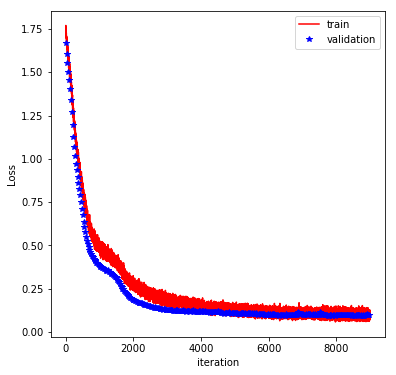

In [12]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 25 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

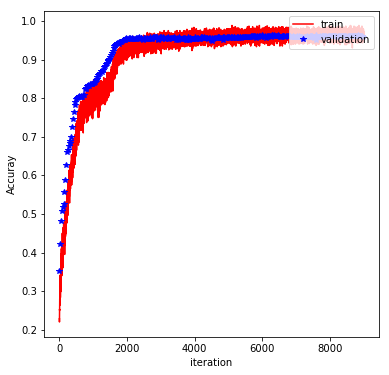

In [13]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 25 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [14]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1,
                initial_state: test_state}
        
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints/har-lstm.ckpt
Test accuracy: 0.890417
